In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [3]:
# Load the dataset
data = pd.read_csv("HeartDisease.csv")

# Fill missing values....... fill with mean median mode depending on data type

# For numerical columns
numerical_cols = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'cigsPerDay', 'age']
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# For categorical columns
categorical_cols = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


# Determine the split indices according to the requirements
total_rows = len(data)
train_end = int(total_rows * 0.7)
val_end = int(total_rows * 0.85)

# Split the dataset
train_data = data.iloc[:train_end]
val_data = data.iloc[train_end:val_end]
test_data = data.iloc[val_end:]

# Separate features and target variable if you have one (uncomment and adjust if needed)
X_train = train_data.drop('HeartDisease', axis=1)
Y_train = train_data['HeartDisease']

X_val = val_data.drop('HeartDisease', axis=1)
Y_val = val_data['HeartDisease']

X_test = test_data.drop('HeartDisease', axis=1)
Y_test = test_data['HeartDisease']

# Check the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 2966
Validation set size: 636
Test set size: 636


In [4]:
#converting the pandas dataframe to numpy array

X_train = X_train.values
Y_train = Y_train.values

X_test = X_test.values
Y_test = Y_test.values

X_val = X_val.values
Y_val = Y_val.values


In [5]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [6]:
def accuracy(predictions, groundTruth):
  return np.mean(predictions == groundTruth)* 100

In [15]:
class LogisticRegression():

    def __init__(self, learningRate, epochs):
        self.learningRate = learningRate
        self.epochs = epochs
        self.weights = None
        self.bias = None

        self.costList = None
        self.accuracyList = None

    def getLoss(self):
      return self.costList

    def getAccuracy(self):
      return self.accuracyList

    def batchGradientDescent(self, X, Y):
        m, n = X.shape
        self.weights = np.ones(n) #initialising the weights as 0s
        self.bias = 1 #initialising the bias as zero

        self.costList = []
        self.accuracyList = []

        epsilon = 1e-10  # Small constant to prevent log(0)

        for _ in range(self.epochs):

            hypothesis = np.dot(X, self.weights) + self.bias
            Y_prediction = sigmoid(hypothesis)

            # Cost Function J(w, b), cross entropy loss
            cost = -(1/m) * np.sum(Y * np.log(Y_prediction + epsilon) + (1 - Y) * np.log(1 - Y_prediction + epsilon))

            #Accuracy
            classification = [0 if y<=0.5 else 1 for y in Y_prediction]
            acc = accuracy(classification, Y)

            self.costList.append(cost)
            self.accuracyList.append(acc)

            #calculating the gradients (partial derivative of the cost function J(w, b) wrt weights and bias)
            dw = (1/m) * np.dot(X.T, (Y_prediction - Y))
            db = (1/m) * np.sum(Y_prediction - Y)

            self.weights = self.weights - self.learningRate * dw
            self.bias = self.bias - self.learningRate * db

            # if _ % (self.epochs // 10) == 0:  # Print cost every 10% of iterations
            #     print(f"Cost after {_} iterations: {cost} & accuracy : {acc}")


    def stochasticGradientDescent(self, X, Y):
        m, n = X.shape
        self.weights = np.ones(n) #initialising the weights as 1s
        self.bias = 1 #initialising the bias as ones

        self.costList = []
        self.accuracyList = []

        epsilon = 1e-10

        for i in range(self.epochs):

            for j in range(m):
                random_index = np.random.randint(m) 

                X_sample = X[random_index].reshape(1, -1) #converting the 1D array into a 2D array for compatibility
                Y_sample = Y[random_index].reshape(1,) #converting a scalar into an array of size 1

                # hypothesis/ model for prediction
                hypothesis = np.dot(X_sample, self.weights) + self.bias
                Y_predicted = sigmoid(hypothesis)

                # Gradients for one sample
                dw = np.dot(X_sample.T, (Y_predicted - Y_sample))
                db = Y_predicted - Y_sample

                # Update weights
                self.weights -= self.learningRate * dw
                self.bias -= self.learningRate * db

            Y_pred = sigmoid(np.dot(X, self.weights) + self.bias)
            # Cost Function J(w, b), cross entropy loss
            cost = -(1/m) * np.sum(Y * np.log(Y_pred + epsilon) + (1 - Y) * np.log(1 - Y_pred + epsilon))

            #Accuracy
            classification = [0 if y<=0.5 else 1 for y in Y_pred]
            acc = accuracy(classification, Y)

            self.costList.append(cost)
            self.accuracyList.append(acc)

            # if i % (self.epochs // 10) == 0:  # Print cost every 10% of iterations
            #     print(f"Cost after {i} iterations: {cost} & accuracy : {acc}")


    def miniBatchGradientDescent(self, X, Y, batchSize):

        m, n = X.shape
        self.weights = np.ones(n)  # initializing the weights as 1s
        self.bias = 1  # initializing the bias as 1

        self.costList = []
        self.accuracyList = []

        epsilon = 1e-10
        numBatches = m // batchSize

        for i in range(self.epochs):
            # Shuffle data at the beginning of each epoch
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            for j in range(numBatches):
                X_batch = X_shuffled[j * batchSize:(j + 1) * batchSize]
                Y_batch = Y_shuffled[j * batchSize:(j + 1) * batchSize]

                # Hypothesis / model for prediction
                hypothesis = np.dot(X_batch, self.weights) + self.bias
                Y_predicted = sigmoid(hypothesis)

                # Gradients for the mini-batch
                dw = np.dot(X_batch.T, (Y_predicted - Y_batch)) / batchSize
                db = np.sum(Y_predicted - Y_batch) / batchSize

                # Update weights
                self.weights -= self.learningRate * dw
                self.bias -= self.learningRate * db

            # Calculate cost for the full dataset
            Y_pred = sigmoid(np.dot(X, self.weights) + self.bias)
            cost = -(1/m) * np.sum(Y * np.log(Y_pred + epsilon) + (1 - Y) * np.log(1 - Y_pred + epsilon))

            # Accuracy
            classification = [0 if y <= 0.5 else 1 for y in Y_pred]
            acc = accuracy(classification, Y)

            self.costList.append(cost)
            self.accuracyList.append(acc)

            # if i % (self.epochs // 10) == 0:  # Print cost every 10% of iterations
            #     print(f"Cost after {i} iterations: {cost} & accuracy: {acc}")



    def classify(self, X):
        m, n = X.shape

        hypothesis = np.dot(X, self.weights) + self.bias
        Y_prediction = sigmoid(hypothesis)

        classLabels = [0 if y <= 0.5 else 1 for y in Y_prediction]

        return classLabels

In [8]:
def fit_min_max_scaling(X):
    return (X - X.min()) / (X.max() - X.min())

In [17]:
# using the logistic regression model with learning rate and number of iters passed as parameters

# Initialize the model
learningRate = 0.0001
epochs = 80

X_train = fit_min_max_scaling(X_train)
X_val = fit_min_max_scaling(X_val)

model_bgd = LogisticRegression(0.05, 400)
model_sgd = LogisticRegression(0.0001, 80)
model_mbgd = LogisticRegression(0.05, 100)

# Training with Batch GD
model_bgd.batchGradientDescent(X_train, Y_train)
bgdLoss = model_bgd.getLoss()
bgdAccuracy = model_bgd.getAccuracy()

print("-----------------###-----###----###-------------------")

# Training with SGD
model_sgd.stochasticGradientDescent(X_train, Y_train)
sgdLoss = model_sgd.getLoss()
sgdAccuracy = model_sgd.getAccuracy()

print("-----------------###-----###----###-------------------")

# Training with Mini-batch GD
batchSizes = [100, 500, 900]  # List of batch sizes
batchSizeResults = {}
mbgdBestAccuracy = 0

for batchSize in batchSizes:
    model_mbgd.miniBatchGradientDescent(X_train, Y_train, batchSize)
    mbgdLoss = model_mbgd.getLoss()
    mbgdAccuracy = model_mbgd.getAccuracy()
    batchSizeResults[batchSize] = (mbgdLoss, mbgdAccuracy)



In [16]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Assuming fit_min_max_scaling is a function you already have for scaling your data
# X_train = fit_min_max_scaling(X_train)
# X_val = fit_min_max_scaling(X_val)

# # Initialize your models with learning rate and epochs
# model_bgd = LogisticRegression(learningRate=0.05, epochs=400)
# model_sgd = LogisticRegression(learningRate=0.0001, epochs=80)
# model_mbgd = LogisticRegression(learningRate=0.05, epochs=100)

# # Dictionary to store evaluation results
# evaluation_results = {}

# # Training and evaluating with Batch GD
# model_bgd.batchGradientDescent(X_train, Y_train)
# Y_pred_bgd = model_bgd.classify(X_val)  # Predict on validation set

# evaluation_results['BatchGD'] = {
#     'accuracy': accuracy_score(Y_val, Y_pred_bgd),
#     'precision': precision_score(Y_val, Y_pred_bgd),
#     'recall': recall_score(Y_val, Y_pred_bgd),
#     'f1_score': f1_score(Y_val, Y_pred_bgd)
# }

# print("-----------------###-----###----###-------------------")

# # Training and evaluating with SGD
# model_sgd.stochasticGradientDescent(X_train, Y_train)
# Y_pred_sgd = model_sgd.classify(X_val)  # Predict on validation set

# evaluation_results['SGD'] = {
#     'accuracy': accuracy_score(Y_val, Y_pred_sgd),
#     'precision': precision_score(Y_val, Y_pred_sgd),
#     'recall': recall_score(Y_val, Y_pred_sgd),
#     'f1_score': f1_score(Y_val, Y_pred_sgd)
# }

# print("-----------------###-----###----###-------------------")

# # Training and evaluating with Mini-batch GD
# batchSizes = [100, 500, 900]  # List of batch sizes
# batchSizeResults = {}

# for batchSize in batchSizes:
#     model_mbgd.miniBatchGradientDescent(X_train, Y_train, batchSize=batchSize)
#     Y_pred_mbgd = model_mbgd.classify(X_val)  # Predict on validation set

#     batchSizeResults[batchSize] = {
#         'accuracy': accuracy_score(Y_val, Y_pred_mbgd),
#         'precision': precision_score(Y_val, Y_pred_mbgd),
#         'recall': recall_score(Y_val, Y_pred_mbgd),
#         'f1_score': f1_score(Y_val, Y_pred_mbgd)
#     }

# # Print evaluation results for all models
# for method, metrics in evaluation_results.items():
#     print(f"{method} Results:")
#     print(f"Accuracy: {metrics['accuracy']:.4f}")
#     print(f"Precision: {metrics['precision']:.4f}")
#     print(f"Recall: {metrics['recall']:.4f}")
#     print(f"F1 Score: {metrics['f1_score']:.4f}")
#     print("-----------------###-----###----###-------------------")

# # Print evaluation results for Mini-batch GD with different batch sizes
# for batchSize, metrics in batchSizeResults.items():
#     print(f"Mini-batch GD Results for batch size {batchSize}:")
#     print(f"Accuracy: {metrics['accuracy']:.4f}")
#     print(f"Precision: {metrics['precision']:.4f}")
#     print(f"Recall: {metrics['recall']:.4f}")
#     print(f"F1 Score: {metrics['f1_score']:.4f}")
#     print("-----------------###-----###----###-------------------")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------###-----###----###-------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------###-----###----###-------------------
BatchGD Results:
Accuracy: 0.8585
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
-----------------###-----###----###-------------------
SGD Results:
Accuracy: 0.8585
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
-----------------###-----###----###-------------------
Mini-batch GD Results for batch size 100:
Accuracy: 0.8585
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
-----------------###-----###----###-------------------
Mini-batch GD Results for batch size 500:
Accuracy: 0.8585
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
-----------------###-----###----###-------------------
Mini-batch GD Results for batch size 900:
Accuracy: 0.8585
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
-----------------###-----###----###-------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


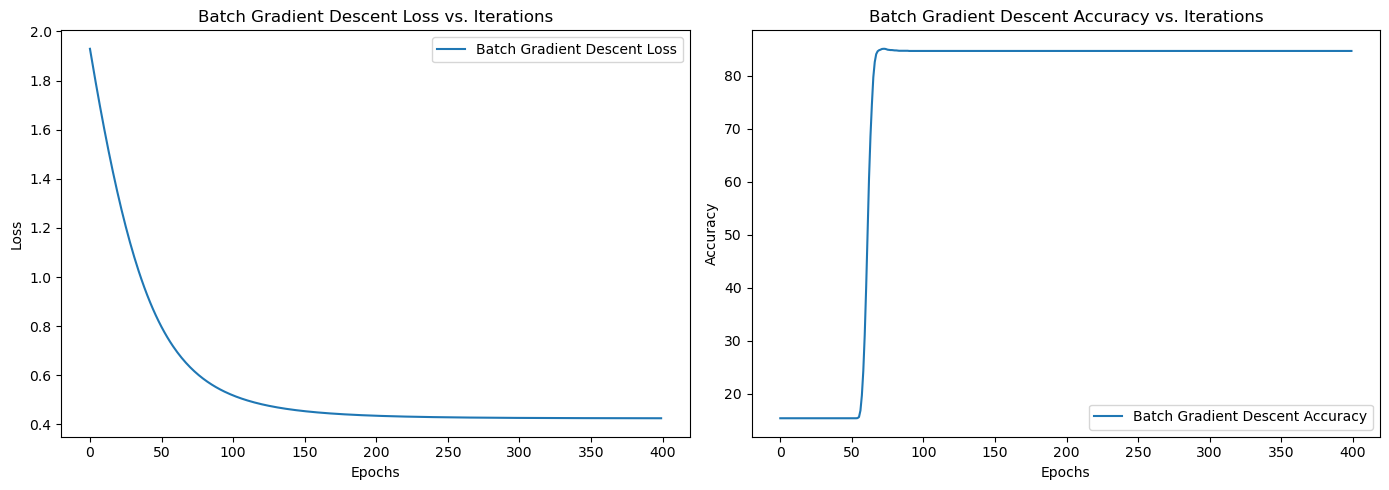

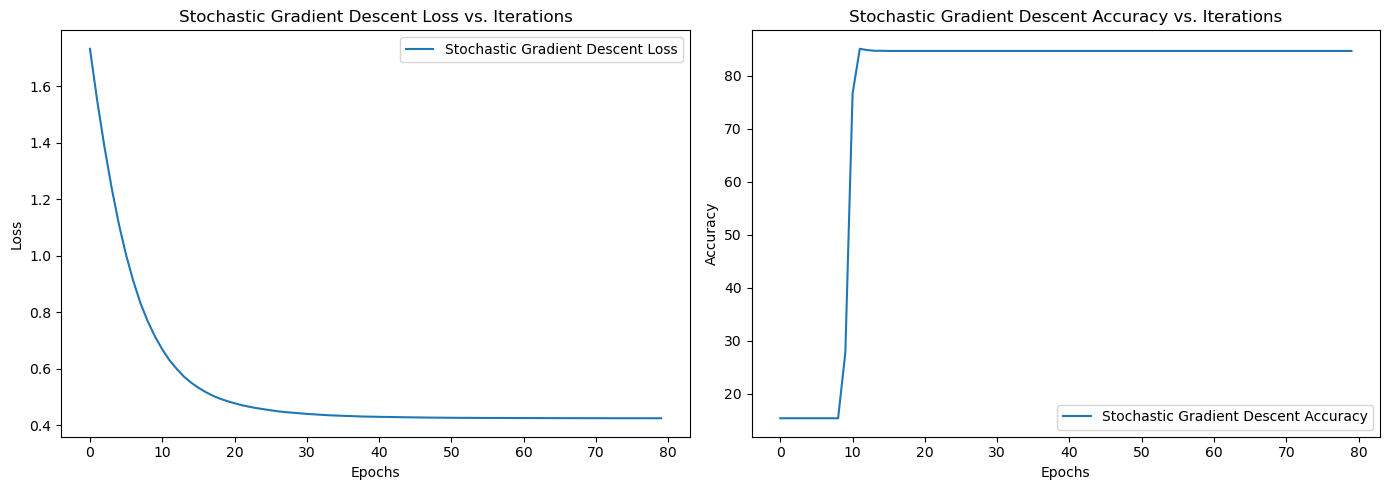

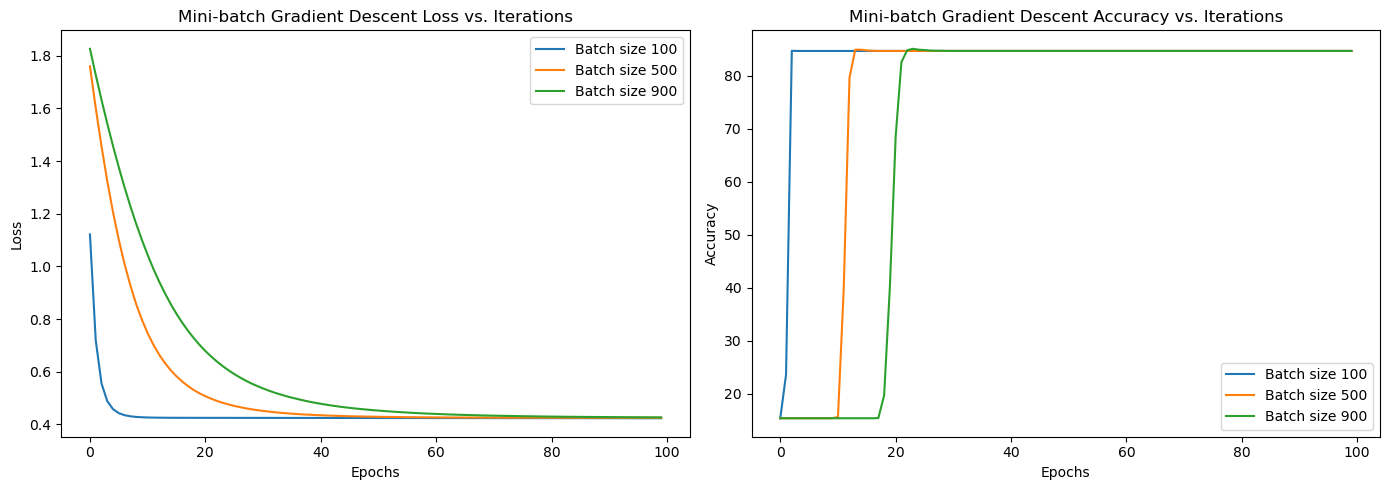

In [21]:
def plotMethodResults(loss, accuracy, methodName):
    epochs = len(loss)

    plt.figure(figsize=(14, 5))

    # Plotting Loss vs. Iterations
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss, label=f'{methodName} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{methodName} Loss vs. Iterations')
    plt.legend()

    # Plotting Accuracy vs. Iterations
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy, label=f'{methodName} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{methodName} Accuracy vs. Iterations')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot loss and accuracy for multiple batch sizes in the same graph
def plotBatchSizeComparison(batchSizeResults, metricName):
    plt.figure(figsize=(14, 5))

    for batchSize, (loss, accuracy) in batchSizeResults.items():
        epochs = len(loss)

        # Plot Loss vs. Iterations
        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), loss, label=f'Batch size {batchSize}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{metricName} Loss vs. Iterations')
        plt.legend()

        # Plot Accuracy vs. Iterations
        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), accuracy, label=f'Batch size {batchSize}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'{metricName} Accuracy vs. Iterations')
        plt.legend()

    plt.tight_layout()
    plt.show()


# Plot the results separately
plotMethodResults(bgdLoss, bgdAccuracy, 'Batch Gradient Descent')
plotMethodResults(sgdLoss, sgdAccuracy, 'Stochastic Gradient Descent')
# Plot the results for all batch sizes in the same graph
plotBatchSizeComparison(batchSizeResults, 'Mini-batch Gradient Descent')